<a href="https://colab.research.google.com/github/rlberry-py/rlberry/blob/main/notebooks/experimental_pipeline_with_rlberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimental pipeline with `rlberry`

In this notebook, you will see:

* How to use the `AgentStats` class to compare two deep RL algorithms: `A2C` and `PPO`
* How `AgentStats` can optimize hyperparameters with one line of code (thanks to `Optuna`).
* How to save all the parameters of the experiments in a `config.json` file (using `Sacred`).

# Colab setup

In [1]:
# install rlberry library, full version
!git clone https://github.com/rlberry-py/rlberry.git 
!cd rlberry && git pull && pip install -e .[full] > /dev/null 2>&1

# install ffmpeg-python for saving videos
!pip install ffmpeg-python > /dev/null 2>&1

# install optuna for hyperparameter optimization
!pip install optuna > /dev/null 2>&1

# packages required to show video
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

print("")
print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
print("")

Cloning into 'rlberry'...
remote: Enumerating objects: 619, done.
remote: Counting objects: 100% (619/619), done.
remote: Compressing objects: 100% (403/403), done.
remote: Total 3045 (delta 368), reused 406 (delta 213), pack-reused 2426
Receiving objects: 100% (3045/3045), 804.06 KiB | 7.81 MiB/s, done.
Resolving deltas: 100% (1887/1887), done.
Already up to date.

 ~~~  Libraries installed, please restart the runtime! ~~~ 



# Imports and experiment setup

In [8]:
# Clear ouput dir
!rm -r experiment_dir/*

In [9]:
import rlberry.seeding as seeding
from rlberry.agents import PPOAgent, A2CAgent
from rlberry.envs.benchmarks.ball_exploration.ball2d import get_benchmark_env
from rlberry.stats import AgentStats, compare_policies, plot_episode_rewards
from sacred import Experiment
from sacred.observers import FileStorageObserver

from sacred import SETTINGS
SETTINGS['CAPTURE_MODE'] = 'sys' # workaround to avoid problems with sacred + multiprocessing (https://github.com/IDSIA/sacred/issues/711)

# Create experiment
ex = Experiment('demo_ppo_vs_a2c', interactive=True)  # interactive only for the notebook

# Create output folder to store configs
fs_observer = FileStorageObserver.create("experiment_dir")
ex.observers.append(fs_observer)

In [10]:
@ex.config
def cfg():
    """
    Defines experiment parameters, using the Sacred library.
    See Sacred documentation at https://sacred.readthedocs.io/en/stable/
    """
    params = {}
    params['ppo'] = {
                    "n_episodes": 100,
                    "gamma": 0.99,
                    "horizon": 50,
                    }

    params['a2c'] = {
                    "n_episodes": 100,
                    "gamma": 0.99,
                    "horizon": 50,
                    }

    optimize_hyperparams = True

    rlberry_seed = 123


# Run experiment

[INFO] Running command 'run_experiment' 
[INFO] Started run with ID "1" 
[I 2020-12-01 12:45:45,531] A new study created in memory with name: no-name-c553da79-72cc-47f7-b9ce-424abbd44bf2
[INFO] [PPO] | episode = 25.000 | ep reward = 0.480 | freq = 27.992 logs/ms 
[INFO] [PPO] | episode = 25.000 | ep reward = 8.044 | freq = 27.826 logs/ms 
[INFO] [PPO] | episode = 50.000 | ep reward = 0.359 | freq = 20.057 logs/ms 
[INFO] [PPO] | episode = 50.000 | ep reward = 2.753 | freq = 19.934 logs/ms 
[INFO] [PPO] | episode = 75.000 | ep reward = 0.026 | freq = 22.385 logs/ms 
[INFO] [PPO] | episode = 75.000 | ep reward = 4.065 | freq = 21.622 logs/ms 
[INFO] [PPO] | episode = 100.000 | ep reward = 0.406 | freq = 24.612 logs/ms 
[INFO] [PPO] | episode = 100.000 | ep reward = 3.804 | freq = 24.956 logs/ms 
[I 2020-12-01 12:45:51,363] Trial 1 finished with value: 0.10280699071069384 and parameters: {'batch_size': 64, 'learning_rate': 0.040040842609794736}. Best is trial 1 with value: 0.1028069907106

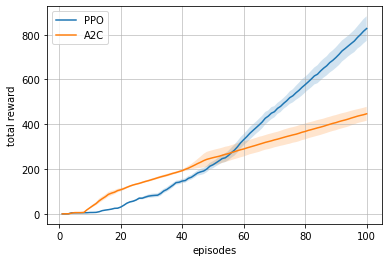

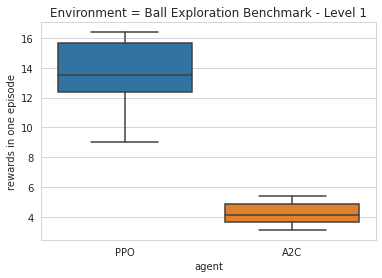

[INFO] Completed after 0:00:38 


         PPO       A2C
0  15.796763  5.410952
1  12.995721  3.851343
2  16.386682  3.481529
3  16.185346  3.122430
4  12.048446  3.553358
5  13.383890  5.176494
6   9.037517  4.253447
7  13.606320  3.995919
8  15.206549  4.464988
9  12.169362  4.961921


In [11]:
@ex.main
def run_experiment(rlberry_seed,
                   params,
                   optimize_hyperparams):
    """
    Main experiment function
    """   
    # Set seed
    seeding.set_global_seed(rlberry_seed)
    # Choose environment
    env = get_benchmark_env(level=1)

    # Initialize AgentStats
    stats = {}
    stats['ppo'] = AgentStats(PPOAgent,
                              env,
                              init_kwargs=params['ppo'],
                              eval_horizon=params['ppo']['horizon'],
                              n_fit=4,
                              output_dir=fs_observer.dir)  # set ouput_dir as the one used by Sacred

    stats['a2c'] = AgentStats(A2CAgent,
                              env,
                              init_kwargs=params['a2c'],
                              eval_horizon=params['a2c']['horizon'],
                              n_fit=4,
                              output_dir=fs_observer.dir)

    agent_stats_list = stats.values()

    # Optimize hyperparameters
    # For more information on how optimize_hyperparams work,
    # readers are invited to consult the documentation of Optuna:
    # https://optuna.readthedocs.io/en/stable/
    if optimize_hyperparams:
        for stats in agent_stats_list:
            # timeout after 10 seconds
            stats.optimize_hyperparams(n_trials=50, timeout=10, n_fit=1)
    
    # Fit agents with optimized hyperparams, and save results
    for stats in agent_stats_list:
        stats.fit()
        stats.save_results()

    # Learning curves
    plot_episode_rewards(agent_stats_list, cumulative=True, show=False)

    # Compare final policies
    output = compare_policies(agent_stats_list, n_sim=10)
    print(output)


ex.run()

# Check output

In [13]:
# Input configuration
!cat experiment_dir/1/config.json
# Optimized hyperparameters
!cat experiment_dir/1/best_hyperparams_A2C.json
!cat experiment_dir/1/best_hyperparams_PPO.json

# And other output files (.csv with episode rewards, for instance)
!ls experiment_dir/1/

{
  "__doc__": "\nDefines experiment parameters, using the Sacred library.\nSee Sacred documentation at https://sacred.readthedocs.io/en/stable/\n",
  "optimize_hyperparams": true,
  "params": {
    "a2c": {
      "gamma": 0.99,
      "horizon": 50,
      "n_episodes": 100
    },
    "ppo": {
      "gamma": 0.99,
      "horizon": 50,
      "n_episodes": 100
    }
  },
  "rlberry_seed": 123,
  "seed": 304295250
}{
    "batch_size": 8,
    "learning_rate": 0.02252913895362045
}{
    "batch_size": 16,
    "learning_rate": 0.00248290562404564
}best_hyperparams_A2C.json  cout.txt	 stats_episode_rewards_A2C.csv
best_hyperparams_PPO.json  metrics.json  stats_episode_rewards_PPO.csv
config.json		   run.json
